## Processo Seletivo UNIMED - Lucas Domiciano Granso

Primeiramente temos que as linhas de SQL foram feita e aplicadas , a principio , utilizando o DBeaver e depois de serem aplicadas e checadas foi necessária a utilização da biblioteca sqlite3 com o intuito de subir e utilizar o Google Collab. Com isso algumas adaptações tiveram que ser feitas para o propósito seja aplicado ao que se pede no processo seletivo.

Com isso , os primeiros passos são a importação das seguintes bibliotecas: `sqlite3`,`pandas` e `numpy`

In [4]:
import sqlite3
import pandas as pd
import numpy as np

 #### Importação de dados

 Os dados que foram entregues para mim serão importados através do drive, já que não está sendo possível fazer o upload neste arquivo. Como no exercício se pede para que exista uma identificação entre os relacionamentos das bases irei mostrar pós a leitura dos dados.

In [5]:
#forma de conseguir rodar utilizando local
beneficiarios = pd.read_excel("Beneficiarios.xlsx")
plano =pd.read_excel("Utilizacao_plano_saude.xlsx")
prestadores =pd.read_excel("Prestadores.xlsx")
servicos = pd.read_excel("Servico.xlsx")

In [22]:
#unica forma que eu consegui rodar utilizando o collab
beneficiarios = pd.read_excel("drive/MyDrive/Dados - Teste engenheiro de dados/Beneficiarios.xlsx")
plano =pd.read_excel("drive/MyDrive/Dados - Teste engenheiro de dados/Utilizacao_plano_saude.xlsx")
prestadores =pd.read_excel("drive/MyDrive/Dados - Teste engenheiro de dados/Prestadores.xlsx")
servicos = pd.read_excel("drive/MyDrive/Dados - Teste engenheiro de dados/Servico.xlsx")

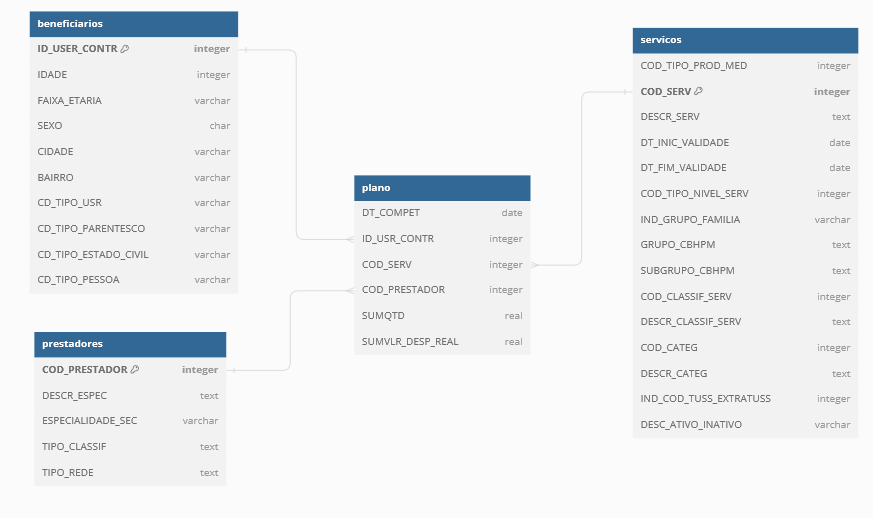

Como pode-se perceber acima, o que não se trata da melhor visualização possível, que existe conexões entre  a tabela plano e todas as outras tabelas , enquanto prestadores , servicos e benenfiarios não possuem conexão alguma

Agora iremos criar a variável connn para que as queries possam ser aplicadas e os resultados desejados possam ser extraídos

In [ ]:
conn = sqlite3.connect("sqldb")

Agora iremos escrever as tabelas desta forma com o intuito de economizar tempo e agilizar os porecessos

In [ ]:
beneficiarios.to_sql('beneficiarios',conn,if_exists='replace')
plano.to_sql('plano',conn,if_exists='replace')
prestadores.to_sql('prestadores',conn,if_exists='replace')
servicos.to_sql('servicos',conn,if_exists='replace')

142167

### Questão A

Quantas consultas em consultório foram realizadas no primeiro semestre de 2022, para beneficiários de contrato PJ, do sexo feminino, residentes em indaiatuba?

In [ ]:
resposta_1=pd.read_sql_query('''select COUNT(s.COD_SERV) contador
FROM servicos s
JOIN plano p
ON s.COD_SERV  = p.COD_SERV
JOIN beneficiarios b
ON p.ID_USR_CONTR  = b.ID_USR_CONTR
WHERE b.SEXO = 'F'
AND b.CIDADE = 'INDAIATUBA'
AND b.CD_TIPO_PESSOA = 'PJ'
AND s.GRUPO_CBHPM = "CONSULTAS"
AND s.DESCR_SERV LIKE '%CONSULTORIO%'
AND p.DT_COMPET >= '2022-01-01' AND p.DT_COMPET <'2022-07-01'
''',conn)
resposta_1

,contador
0,1092


Note que acima conseguimos filtrar por cidade `b.CIDADE = 'INDAIATUBA'`, sexo `b.SEXO = 'F'`, se é PJ `AND b.CD_TIPO_PESSOA = 'PJ'` se são consultas `AND s.GRUPO_CBHPM = "CONSULTAS"`, do primeiro semestre de 2022 `AND p.DT_COMPET >= '2022-01-01' AND p.DT_COMPET <'2022-07-01'` e se foram em consultorio `AND s.DESCR_SERV LIKE '%CONSULTORIO%'`.

Com isso adicionamos um contador dos códigos de serviço que nos retorna a quantidade de consultas em consultorio desta população.

### Questão B

b(1) A partir desses beneficiários, além das consultas, qual o tipo de serviço mais utilizado? b(2) Qual o principal prestador relacionado e qual o valor com esse
serviço/prestador?

##### B

Para apergunta acima eu separei em duas partes, onde a parte b(1) irá ser utilizada como uma sub query para que b(2) seja responsdida.

Para b(1) temos:

In [ ]:
resposta_b1 = pd.read_sql_query('''
SELECT s.GRUPO_CBHPM
FROM servicos s
JOIN plano p
ON s.COD_SERV  = p.COD_SERV
JOIN beneficiarios b
ON p.ID_USR_CONTR  = b.ID_USR_CONTR
WHERE b.SEXO = 'F' AND b.CIDADE = 'INDAIATUBA' AND b.CD_TIPO_PESSOA = 'PJ' AND s.GRUPO_CBHPM != "CONSULTAS"
group by s.GRUPO_CBHPM
order by count(*) desc
limit 1
''',conn)
resposta_b1

,GRUPO_CBHPM
0,MEDICINA LABORATORIAL


Para além das consultas , Medicina Laboratorial é o tipo de serviço mais utilizado

In [ ]:
resposta_b2 = pd.read_sql_query('''
select p.COD_PRESTADOR codigo_prestador,count(p.COD_PRESTADOR) contador_prestador ,
SUM(p."SUM(VLR_DESP_REAL)") soma_final,
AVG(p."SUM(VLR_DESP_REAL)") media_final
from plano p
join servicos s
on p.COD_SERV = s.COD_SERV
where s.GRUPO_CBHPM IS (SELECT s.GRUPO_CBHPM
FROM servicos s
JOIN plano p
ON s.COD_SERV  = p.COD_SERV
JOIN beneficiarios b
ON p.ID_USR_CONTR  = b.ID_USR_CONTR
WHERE b.SEXO = 'F' AND b.CIDADE = 'INDAIATUBA' AND b.CD_TIPO_PESSOA = 'PJ' AND s.GRUPO_CBHPM != "CONSULTAS"
group by s.GRUPO_CBHPM
order by count(*) desc
limit 1
)
group by p.COD_PRESTADOR
order by contador_prestador desc
limit 1''',conn)
resposta_b2


,codigo_prestador,contador_prestador,soma_final,media_final
0,19134,125617,1832143.2,14.585153


Utilizamos o item b(1) para que seja possível extrair as informações do principal prestador relacionado a medicina laboratorial e o valor do mesmo . Como podemos ver no dataframe acima onde podemos ver o principal prestador ('Código do Prestador') relacionado, qual o valor do serviço em somatória e quantas vezes o servico foi contado ('contador prestador')

### Questão C


c. Médicos ginecologistas possuem quantos beneficiários em sua carteira? Trazer levantamento aberto por médico e a quantidade de beneficiários na carteira. A carteira é composta por beneficiários que passaram pelo menos 2x no mesmo médico durante o ano.


Para esta questão , filtrou-se os dados e criou-se uma nova tabela na qual seria possível trabalhar sobre

In [ ]:
cur = conn.cursor()
cur.execute('''
create table prestador_cliente as
select distinct b.ID_USR_CONTR as "Código da pessoa", COUNT(p2.COD_PRESTADOR) "Numero de consultas", p2.COD_PRESTADOR
from prestadores p2
join plano p
on p2.COD_PRESTADOR = p.COD_PRESTADOR
join beneficiarios b
on p.ID_USR_CONTR =b.ID_USR_CONTR
where p2.DESCR_ESPEC = 'GINECOLOGIA E OBSTETRICIA'
and p2.TIPO_CLASSIF LIKE "%PF%"
group by b.ID_USR_CONTR
having "Numero de consultas">1
order by "Numero de consultas"
''')


Acima conseguimos visualzar que criou-se uma tabela chamada prestador clientes onde se retorna uma tabela com os Códigos dos Indivíduos , o Número de Consultas e o código do prestador. Com isso se torna possível agrupar por Código do prestador e contar quantas pessoas atendeu.

In [ ]:
resposta_3 = pd.read_sql_query('''
select count("Código da Pessoa") "Total de Beneficiarios", COD_PRESTADOR "Código do Prestador"
from prestador_cliente
group by "Código do Prestador"
 ''',conn)

In [ ]:
resposta_3

,Total de Beneficiarios,Código do Prestador
0,31,228
1,43,240
2,4,254
3,5,273
4,61,279
...,...,...
285,23,564955
286,68,566241
287,19,613783
288,14,641853


E com isso temos os resultados acima.